# Comparative YouTube Sentiment Analysis of iPhone 15, Samsung S24, and Google Pixel 7 5G

In today's highly competitive smartphone market, customer perception plays a crucial role in shaping brand success and influencing purchase decisions. With platforms like YouTube serving as major outlets for user expression and product reviews, analyzing sentiment from these sources provides valuable insights into public opinion.

This project focuses on performing a comparative sentiment analysis of YouTube comments related to three flagship smartphones: **iPhone 15, Samsung Galaxy S24, and Google Pixel 7 5G.** By extracting and analyzing user-generated content from YouTube reviews using Natural Language Processing (NLP) techniques, this project aims to uncover how customers feel about each device — whether positively, negatively, or neutrally.

The analysis uses state-of-the-art transformer models (such as RoBERTa) for sentiment classification and presents visual comparisons across the three devices. This project helps identify trends in customer satisfaction, common issues, praised features, and overall public sentiment — offering valuable insights for consumers, marketers, and product developers alike.

## Import Libraries

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import numpy as np
from pylab import rcParams
import torch
import re
from tqdm import tqdm
rcParams["figure.figsize"] = 10,5

## Reading Youtube Comments Data

In [8]:

def read_device_comments():
    """
    Reads YouTube comments CSV files for iPhone 15, Samsung S24, and Google Pixel.
    
    Returns:
        tuple: DataFrames for iPhone, Samsung, and Pixel comments.
    """

    # Read the CSV file containing YouTube comments for iPhone 15 into a DataFrame
    df_iphone = pd.read_csv("youtube_english_comments_iphone15.csv")

    # Read the CSV file containing YouTube comments for Samsung S24 into a DataFrame
    df_samsung = pd.read_csv("youtube_english_comments_s24.csv")

    #Read the CSV file containing YouTube comments for Google Pixel 7 into a DataFrame
    df_pixel = pd.read_csv("youtube_english_comments_pixel7.csv")

    # Return all three DataFrames 
    return df_iphone, df_samsung, df_pixel


In [10]:
# Unpack and assign DataFrames for iPhone, Samsung, and Pixel YouTube comments
iphone_df, samsung_df, pixel_df = read_device_comments()

## Zero-Shot Classification

In this project, zero-shot classification is used to identify whether a YouTube comment is relevant to the specific smartphone being analyzed — iPhone 15, Samsung S24, or Google Pixel 7.

Since user comments on YouTube can often drift off-topic (e.g., comparing with other devices, talking about unrelated experiences, or general opinions), it’s important to filter out irrelevant comments before performing sentiment analysis

In [19]:
import pandas as pd
import re

# Function to remove URLs from text
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)  # Removes links starting with http or www

# Function to remove emojis and non-ASCII characters from text
def remove_emojis(text):
    return text.encode('ascii', 'ignore').decode('ascii')  # Keeps only ASCII characters

# Function to clean a single comment
def clean_comment(text):
    text = remove_urls(text)             # Remove any URLs
    text = remove_emojis(text)           # Remove emojis
    text = text.lower()                  # Convert to lowercase
    text = ' '.join(text.split())        # Remove extra whitespace
    return text

# Function to clean all comments in a DataFrame
def preprocess_comments(df, comment_column='Comment'):
    """
    Cleans comments and filters out short ones.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing raw comments
        comment_column (str): Column name with the original comments
    
    Returns:
        pd.DataFrame: Cleaned DataFrame with a new 'clean_comment' column
    """
    df = df.copy()  # Create a copy to avoid modifying the original DataFrame

    # Apply cleaning function to each comment
    df['clean_comment'] = df[comment_column].apply(clean_comment)

    # Keep only comments with more than 2 words
    df = df[df['clean_comment'].str.split().str.len() > 2].reset_index(drop=True)

    return df  # Return the cleaned DataFrame


In [21]:

# Clean each DataFrame using the function
iphone_df_clean = preprocess_comments(iphone_df)
samsung_df_clean = preprocess_comments(samsung_df)
pixel_df_clean = preprocess_comments(pixel_df)


In [27]:

def zero_shot_classify(df, text_column='clean_comment', batch_size=16):
    """
    Applies zero-shot classification to a DataFrame of comments using HuggingFace pipeline.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing text to classify.
        text_column (str): Column name with the cleaned comment text.
        batch_size (int): Number of comments to classify per batch.
    
    Returns:
        pd.DataFrame: Original DataFrame with added 'top_label' and 'score' columns.
    """
    
    # Set device to GPU if available, else CPU
    device = 0 if torch.cuda.is_available() else -1

    # Load the zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", 
                          model="valhalla/distilbart-mnli-12-1", 
                          device=device)

    # Define the candidate labels for classification
    candidate_labels = ["Phone", "YouTube reviewer", "YouTube channel", "unrelated"]

    results = []  # To store classification results
    comments = df[text_column].tolist()  # Extract comments as a list

    # Loop through comments in batches
    for i in tqdm(range(0, len(comments), batch_size)):
        batch = comments[i:i+batch_size]  # Slice batch

        output = classifier(batch, candidate_labels)  # Run classification
        
        # If batch contains only one comment, wrap the output in a list
        if isinstance(output, dict):
            output = [output]
        
        # Extract top label and score for each result
        for r in output:
            results.append({
                "top_label": r['labels'][0],  # Label with highest score
                "score": r['scores'][0]       # Corresponding confidence score
            })

    # Create DataFrame from results and concatenate with original DataFrame
    results_df = pd.DataFrame(results)
    final_df = pd.concat([df.reset_index(drop=True), results_df], axis=1)
    
    return final_df


In [29]:
# Apply zero-shot classification to label whether each cleaned comment is relevant to iPhone 15
iphone_df_labeled = zero_shot_classify(iphone_df_clean)

Device set to use cpu
100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [09:32<00:00,  9.39s/it]


In [31]:
# Apply zero-shot classification to label whether each cleaned comment is relevant to Samsung s24
samsung_df_labeled = zero_shot_classify(samsung_df_clean)

Device set to use cpu
100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:52<00:00,  9.28s/it]


In [33]:
# Apply zero-shot classification to label whether each cleaned comment is relevant to Google pixel
pixel_df_labeled = zero_shot_classify(pixel_df_clean)

Device set to use cpu
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [03:27<00:00,  8.63s/it]


In [3]:
iphone_df_labeled.to_csv("iphone_df_labeled.csv",index = False) # Save the labeled iPhone comments to a CSV file

NameError: name 'iphone_df_labeled' is not defined

In [35]:
samsung_df_labeled.to_csv("samsung_df_labeled.csv",index = False) # Save the labeled Samsung comments to a CSV file

In [39]:
pixel_df_labeled.to_csv("pixel_df_labeled.csv", index=False)  # Save the labeled pixel comments to a CSV file

In [5]:
iphone_df_labeled = pd.read_csv("iphone_df_labeled.csv")
samsung_df_labeled = pd.read_csv("samsung_df_labeled.csv")
pixel_df_labeled = pd.read_csv("pixel_df_labeled.csv")

## Filtering Labelled Data

In [7]:
def filter_by_label(df, label="Phone", label_column="top_label"):
    """
    Filters the DataFrame to include only rows where the classification
    top label matches the given label.
    
    Parameters:
        df (pd.DataFrame): The classified DataFrame.
        label (str): The label to filter by. Default is "Phone".
        label_column (str): The column that contains the predicted label.
        
    Returns:
        pd.DataFrame: Filtered DataFrame with only matching label rows.
    """
    # Filter rows where the top label equals the desired label
    filtered_df = df[df[label_column] == label].reset_index(drop=True)
    
    return filtered_df


In [9]:
# Filter only "Phone"-related comments from each DataFrame
iphone_phone_df = filter_by_label(iphone_df_labeled)
samsung_phone_df = filter_by_label(samsung_df_labeled)
pixel_phone_df = filter_by_label(pixel_df_labeled)


In [11]:
len(iphone_phone_df) # finding length of the filtered data of iphone

643

In [51]:
len(samsung_phone_df)   # finding length of the filtered data of samsung

196

In [53]:
len(pixel_phone_df)    # finding length of the filtered data of pixel

232

## RoBERTa Sentiment analysis

To understand how users feel about each smartphone, this project uses RoBERTa, a powerful transformer-based language model developed by Facebook AI, for sentiment analysis.

RoBERTa (Robustly Optimized BERT Pretraining Approach) is known for its strong performance in various NLP tasks. In this project, a fine-tuned RoBERTa sentiment model is used to **classify YouTube comments as positive, neutral, or negative.** This approach enables accurate detection of emotional tone in real-world, informal user comments — providing meaningful insights into public perception of the iPhone 15, Samsung S24, and Google Pixel 7 5G.

In [13]:
def add_id_column(df):
    """
    Adds an 'id' column starting from 1 and places it as the first column.

    Parameters:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with 'id' column added at the front.
    """
    df = df.copy()  # Avoid modifying the original DataFrame

    # Create an 'id' column with values from 1 to len(df)
    df["id"] = range(1, len(df) + 1)

    # Reorder columns to move 'id' to the front
    df = df[["id"] + [col for col in df.columns if col != "id"]]

    return df


In [15]:
iphone_phone_df = add_id_column(iphone_phone_df)   # Add a unique ID column to the iPhone comments DataFrame
samsung_phone_df = add_id_column(samsung_phone_df) # Add a unique ID column to the samsung comments DataFrame
pixel_phone_df = add_id_column(pixel_phone_df)     # Add a unique ID column to the pixel comments DataFrame


In [17]:
# Define the name of the pre-trained sentiment analysis model from Hugging Face model hub
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

# Load the tokenizer associated with the model (used to convert text into model-readable tokens)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Load the actual sentiment analysis model (used to predict sentiment based on tokenized input)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


In [18]:


def polarity_scores_roberta(text):
    """
    Get sentiment scores for a single comment using RoBERTa.

    Parameters:
        text (str): The comment text.

    Returns:
        dict: Dictionary with sentiment scores (neg, neu, pos).
    """
    # Tokenize the input text for the model
    encoded_text = tokenizer(text, return_tensors="pt")
    
    # Get model prediction
    output = model(**encoded_text)

    # Extract scores from output tensor
    scores = output[0][0].detach().numpy()

    # Apply softmax to get probabilities
    scores = softmax(scores)

    # Return as a labeled dictionary
    return {
        "roberta_neg": scores[0],
        "roberta_neu": scores[1],
        "roberta_pos": scores[2]
    }

def apply_roberta_sentiment(df, text_column="clean_comment", id_column="id"):
    """
    Applies RoBERTa sentiment analysis to all comments in a DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame with cleaned comments.
        text_column (str): Column name with the comment text.
        id_column (str): Unique identifier column.

    Returns:
        pd.DataFrame: Original DataFrame with sentiment scores merged.
    """
    results = {}  # Dictionary to store sentiment scores by ID

    # Iterate through each row in the DataFrame with progress bar
    for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            comment = row[text_column]   # Extract cleaned comment
            unique_id = row[id_column]   # Extract unique ID
            sentiment = polarity_scores_roberta(comment)  # Run sentiment
            results[unique_id] = sentiment  # Store result
        except RuntimeError:
            print(f"Runtime error for id {unique_id}")
    
    # Convert dictionary of results to DataFrame and reset index
    result_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": id_column})

    # Merge the sentiment scores with the original DataFrame
    merged_df = result_df.merge(df, how="left", on=id_column)

    return merged_df


In [21]:
# Apply RoBERTa sentiment analysis function to iPhone comments
# This adds sentiment scores (negative, neutral, positive) to each comment
iphone_sentiment_df = apply_roberta_sentiment(iphone_phone_df)

100%|████████████████████████████████████████████████████████████████████████████████| 643/643 [01:04<00:00,  9.95it/s]


In [23]:
# Apply RoBERTa sentiment analysis to Samsung comments
# Output is a DataFrame with original data + sentiment columns
samsung_sentiment_df = apply_roberta_sentiment(samsung_phone_df)

100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:19<00:00, 10.05it/s]


In [25]:

# Apply RoBERTa sentiment analysis to Pixel comments
# Result includes sentiment scores merged with original dataset
pixel_sentiment_df = apply_roberta_sentiment(pixel_phone_df)


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [00:27<00:00,  8.54it/s]


In [27]:
iphone_sentiment_df.head() # First 5 rows of iphone sentiment DataFrame

,id,roberta_neg,roberta_neu,roberta_pos,Comment,clean_comment,top_label,score
0,1,0.032651,0.288044,0.679304,I decided to go with the 15 instead of the 16 ...,i decided to go with the 15 instead of the 16 ...,Phone,0.376676
1,2,0.886026,0.103434,0.010540,"Bro, unable to transfer video files which are ...","bro, unable to transfer video files which are ...",Phone,0.468998
2,3,0.710400,0.236187,0.053413,Perfect phone but refesh rate is the only bad ...,perfect phone but refesh rate is the only bad ...,Phone,0.961925
3,4,0.292945,0.468511,0.238544,I’m upgrading from an iPhone 11 to a 15’ saved...,im upgrading from an iphone 11 to a 15 saved a...,Phone,0.887011
4,5,0.119573,0.769370,0.111057,I counted the word “LITERALLY” around 27 times 😅,i counted the word literally around 27 times,Phone,0.429153


### Assigning Sentiment Label

In [29]:
def assign_sentiment_label(df):
    """
    Assigns a sentiment label based on the highest RoBERTa score.

    Returns:
        pd.DataFrame: DataFrame with 'roberta_sentiment' column added.
    """
    df = df.copy()
    # Identify the column with the highest score and assign sentiment label
    df['roberta_sentiment'] = df[['roberta_neg', 'roberta_neu', 'roberta_pos']].idxmax(axis=1)
    # Convert column names to sentiment labels
    df['roberta_sentiment'] = df['roberta_sentiment'].map({
        'roberta_neg': 'Negative',
        'roberta_neu': 'Neutral',
        'roberta_pos': 'Positive'
    })
    return df


In [31]:
# Assign sentiment labels
iphone_sentiment_df = assign_sentiment_label(iphone_sentiment_df)
samsung_sentiment_df = assign_sentiment_label(samsung_sentiment_df)
pixel_sentiment_df = assign_sentiment_label(pixel_sentiment_df)

In [33]:
iphone_sentiment_df.head()

,id,roberta_neg,roberta_neu,roberta_pos,Comment,clean_comment,top_label,score,roberta_sentiment
0,1,0.032651,0.288044,0.679304,I decided to go with the 15 instead of the 16 ...,i decided to go with the 15 instead of the 16 ...,Phone,0.376676,Positive
1,2,0.886026,0.103434,0.010540,"Bro, unable to transfer video files which are ...","bro, unable to transfer video files which are ...",Phone,0.468998,Negative
2,3,0.710400,0.236187,0.053413,Perfect phone but refesh rate is the only bad ...,perfect phone but refesh rate is the only bad ...,Phone,0.961925,Negative
3,4,0.292945,0.468511,0.238544,I’m upgrading from an iPhone 11 to a 15’ saved...,im upgrading from an iphone 11 to a 15 saved a...,Phone,0.887011,Neutral
4,5,0.119573,0.769370,0.111057,I counted the word “LITERALLY” around 27 times 😅,i counted the word literally around 27 times,Phone,0.429153,Neutral


In [35]:
iphone_sentiment_df.to_csv("iphone_youtube_sentiment.csv",index = False)
samsung_sentiment_df.to_csv("samsung_youtube_sentiment.csv",index = False)
pixel_sentiment_df.to_csv("pixel_youtube_sentiment.csv",index = False)

## RoBERTa Sentiment Distribution 

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_three_sentiment_pie_charts(df1, df2, df3, 
                                     title1="iPhone 15", 
                                     title2="Samsung S24", 
                                     title3="Google Pixel",
                                     sentiment_column="roberta_sentiment"):
    """
    Plots 3 pie charts in a 2-row layout: 
    two on top row and one centered on bottom row.

    Parameters:
        df1, df2, df3 (pd.DataFrame): DataFrames with sentiment labels.
        title1, title2, title3 (str): Titles for each subplot.
        sentiment_column (str): Column name containing sentiment label.
    """
    # Set up the figure with a 2x2 grid
    fig = plt.figure(figsize=(12, 10))  # Overall figure size
    gs = fig.add_gridspec(2, 2)         # GridSpec: 2 rows, 2 columns

    # Top-left subplot (iPhone)
    ax1 = fig.add_subplot(gs[0, 0])
    counts1 = df1[sentiment_column].value_counts()
    ax1.pie(counts1, labels=counts1.index, autopct='%1.1f%%',
            startangle=140, colors=sns.color_palette("pastel"))
    ax1.set_title(title1)

    # Top-right subplot (Samsung)
    ax2 = fig.add_subplot(gs[0, 1])
    counts2 = df2[sentiment_column].value_counts()
    ax2.pie(counts2, labels=counts2.index, autopct='%1.1f%%',
            startangle=140, colors=sns.color_palette("pastel"))
    ax2.set_title(title2)

    # Bottom-center subplot (Pixel) - spans both columns
    ax3 = fig.add_subplot(gs[1, :])
    counts3 = df3[sentiment_column].value_counts()
    ax3.pie(counts3, labels=counts3.index, autopct='%1.1f%%',
            startangle=140, colors=sns.color_palette("pastel"))
    ax3.set_title(title3)

    plt.suptitle("RoBERTa Sentiment Distribution Across Devices", fontsize=16)
    plt.tight_layout(pad=3)  # Adjust layout spacing
    plt.show()


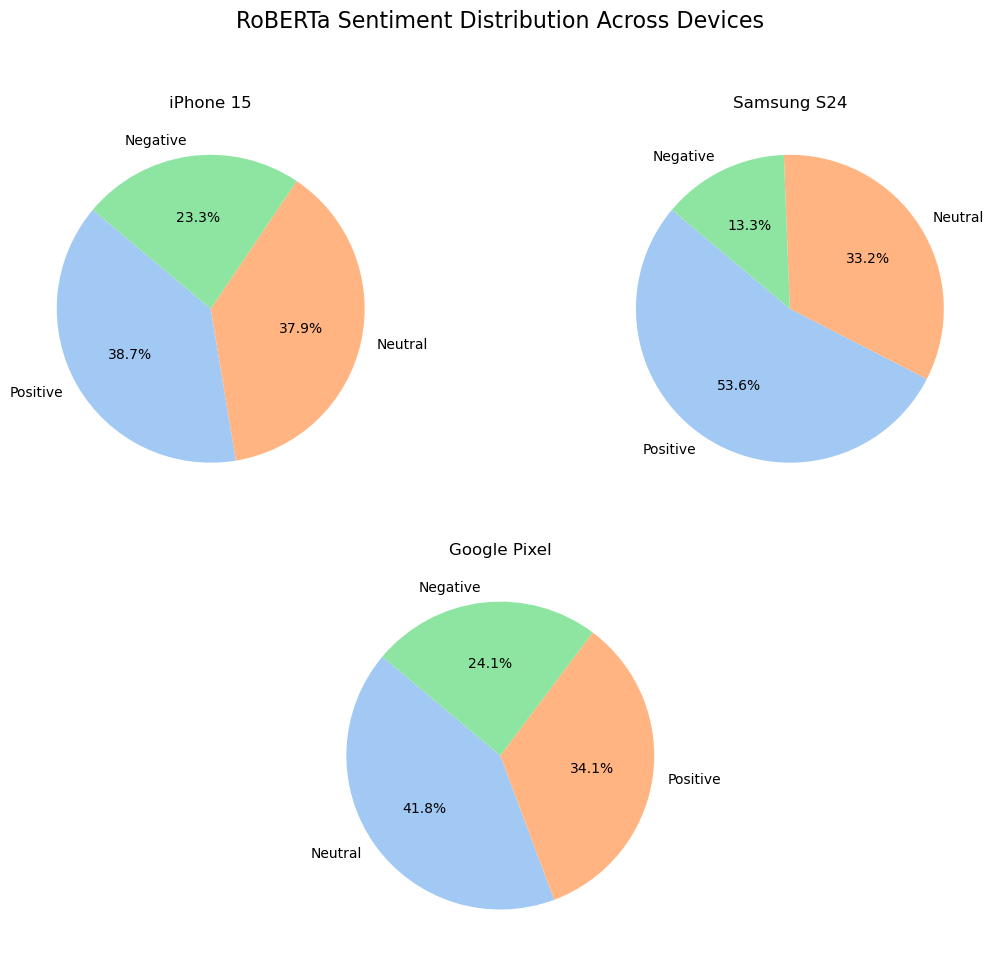

In [39]:
# Make sure all three DataFrames have the 'roberta_sentiment' column
iphone_sentiment_df = assign_sentiment_label(iphone_sentiment_df)
samsung_sentiment_df = assign_sentiment_label(samsung_sentiment_df)
pixel_sentiment_df = assign_sentiment_label(pixel_sentiment_df)

# Plot all three sentiment pie charts in one figure
plot_three_sentiment_pie_charts(iphone_sentiment_df, samsung_sentiment_df, pixel_sentiment_df)


The pie charts above illustrate the sentiment distribution of YouTube comments related to the iPhone 15, Samsung S24, and Google Pixel 7 5G, as determined using a RoBERTa-based sentiment model.

- **iPhone 15** shows a balanced sentiment profile, with 38.7% positive, 37.9% neutral, and 23.3% negative feedback. This suggests that user opinions are fairly divided, with a slight lean toward positive impressions.

- **Samsung S24** stands out with the highest proportion of positive sentiment at 53.6%, and the lowest negative sentiment at 13.3%, indicating a strongly favorable customer response on YouTube.

- **Google Pixel 7 5G** reflects the highest neutral sentiment (41.8%), with 34.1% positive and 24.1% negative. This may indicate mixed reactions or uncertainty among users, possibly due to expectations versus real-world performance.

These insights suggest that Samsung S24 has received the most clearly positive reception, while iPhone 15 garners a more balanced set of opinions, and Google Pixel 7 shows a cautious or divided sentiment landscape among YouTube reviewers.

In [49]:


def compare_sentiment_distribution(dfs, names):
    """
    Creates a grouped bar plot comparing the proportion of RoBERTa sentiment labels
    (Positive, Neutral, Negative) across multiple devices.

    Parameters:
    - dfs (list): List of DataFrames, each with a 'roberta_sentiment' column
    - names (list): List of device names corresponding to each DataFrame
    """
    sentiment_summary = []  # Collect proportions for all devices
    
    # Loop through each DataFrame and associated device name
    for df, name in zip(dfs, names):
        # Get normalized value counts (i.e., relative proportions of each sentiment)
        counts = df['roberta_sentiment'].value_counts(normalize=True)

        # Normalize capitalization to ensure consistent sentiment labels
        for sentiment in ['Positive', 'Neutral', 'Negative']:
            sentiment_summary.append({
                'Device': name,
                'Sentiment': sentiment,
                'Proportion': counts.get(sentiment, 0)  # Use 0 if sentiment is missing
            })

    # Convert summary data to DataFrame
    summary_df = pd.DataFrame(sentiment_summary)

    # Create grouped bar chart using seaborn
    plt.figure(figsize=(10, 4))  # Set the figure size
    sns.barplot(data=summary_df, x='Device', y='Proportion', hue='Sentiment', palette='pastel')

    # Add plot title and labels
    plt.title("Sentiment Distribution by Device (RoBERTa)")
    plt.ylabel("Proportion of Reviews")
    plt.xlabel("Device")
    plt.ylim(0, 1)  # Ensure y-axis represents proportion (0–1)

    # Show legend and plot
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()


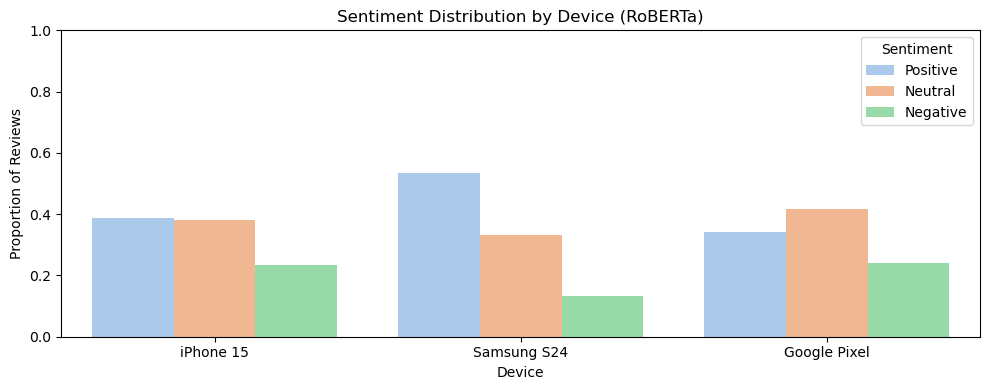

In [51]:
compare_sentiment_distribution(
    dfs=[iphone_sentiment_df, samsung_sentiment_df, pixel_sentiment_df],
    names=["iPhone 15", "Samsung S24", "Google Pixel"]
)


The bar chart above presents the normalized sentiment distribution of YouTube comments for iPhone 15, Samsung S24, and Google Pixel 7, as analyzed using the RoBERTa sentiment model.

- **Samsung S24** stands out with the highest proportion of positive reviews, indicating strong overall satisfaction among YouTube commenters. It also has the lowest proportion of negative sentiment, reinforcing its favorable perception.

- **iPhone 15** shows a fairly balanced sentiment spread, with nearly equal proportions of positive and neutral feedback, and a moderate amount of negative comments.

- **Google Pixel 7** exhibits the highest neutral sentiment, suggesting that many users expressed mixed or non-opinionated views. Its positive and negative sentiments are closely aligned with those of the iPhone 15, but with slightly less enthusiasm.

## Wordcloud

In [53]:


def generate_wordcloud(df, text_column='clean_comment', title="Word Cloud of Reviews"):
    """
    Generates and displays a word cloud from a DataFrame's text column.

    Parameters:
        df (pd.DataFrame): DataFrame containing cleaned text.
        text_column (str): Column name with text data.
        title (str): Title of the word cloud plot.
    """
    # Combine all cleaned text entries into a single string
    text = " ".join(df[text_column].dropna().astype(str))

    # Create a WordCloud object with styling options
    wordcloud = WordCloud(
        width=800,               # Width of the image
        height=400,              # Height of the image
        background_color='white',# Background color
        colormap='viridis',      # Color map for the words
        max_words=200            # Maximum number of words to display
    ).generate(text)             # Generate word cloud from text

    # Display the word cloud using matplotlib
    plt.figure(figsize=(15, 7))          # Set plot size
    plt.imshow(wordcloud, interpolation='bilinear')  # Render the word cloud image
    plt.axis('off')                      # Hide axis ticks
    plt.title(title, fontsize=16)        # Set the plot title
    plt.show()                           # Show the final word cloud


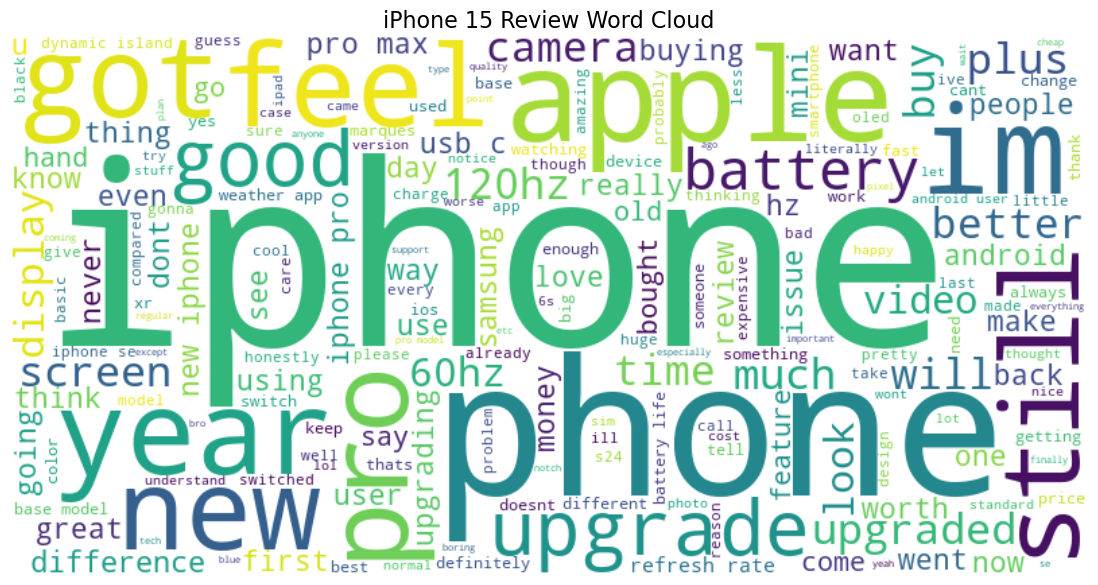

In [59]:
# Generate and display a word cloud of frequently used words in iPhone 15 YouTube comments
generate_wordcloud(iphone_sentiment_df, title="iPhone 15 Review Word Cloud")

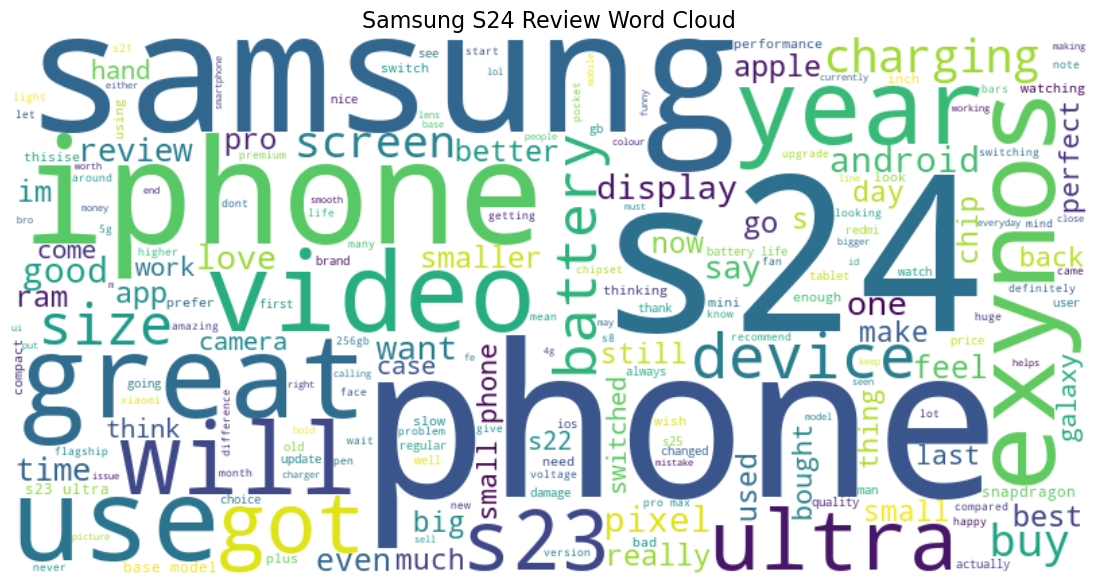

In [61]:
# Generate and display a word cloud of frequently used words in Samsung YouTube comments
generate_wordcloud(samsung_sentiment_df, title="Samsung S24 Review Word Cloud")

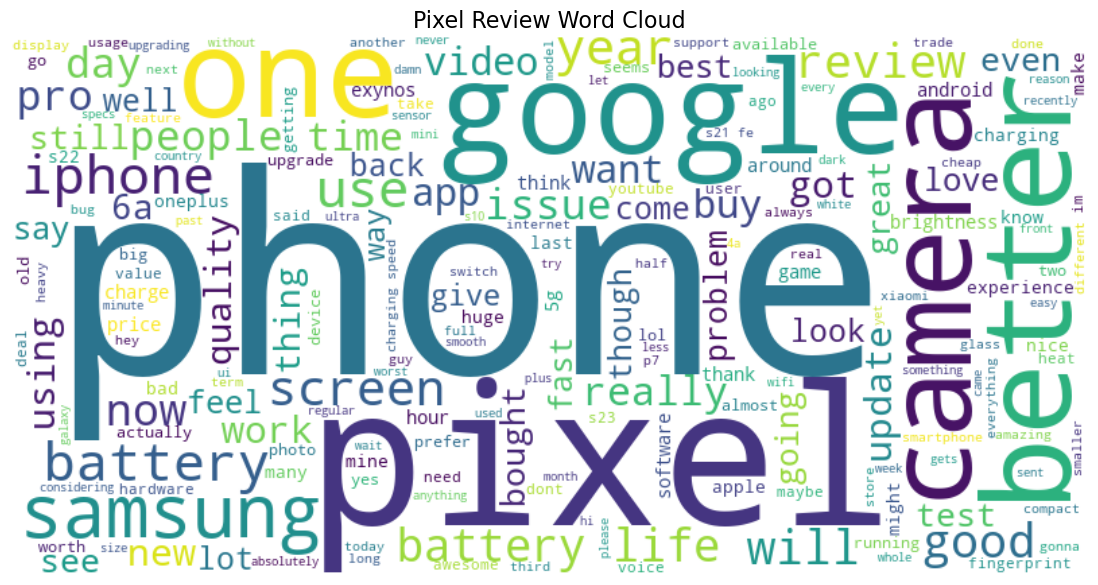

In [63]:
# Generate and display a word cloud of frequently used words in Pixel YouTube comments
generate_wordcloud(pixel_sentiment_df, title="Pixel Review Word Cloud")

## Most Frequent Complaints

In [85]:
# Filter out negative sentiment reviews from iPhone 15 dataset
iphone_neg = iphone_sentiment_df[iphone_sentiment_df['roberta_sentiment'] == 'Negative']

# Filter out negative sentiment reviews from Samsung S24 dataset
s24_neg = samsung_sentiment_df[samsung_sentiment_df['roberta_sentiment'] == 'Negative']

# Filter out negative sentiment reviews from Google Pixel 7 dataset
pixel_neg = pixel_sentiment_df[pixel_sentiment_df['roberta_sentiment'] == 'Negative']

In [77]:
# Load the list of English stopwords into a set for faster lookup
stop_words = set(stopwords.words('english'))

# Function to clean and preprocess a given text string
def clean_text(text):
    text = text.lower()   # Convert text to lowercase for uniformity

    # Remove special characters and punctuation, keep only letters, numbers, and spaces
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    # Tokenize the cleaned text into words
    words = word_tokenize(text)

    # Remove stopwords and short words (less than 3 characters)
    words = [w for w in words if w not in stop_words and len(w) > 2]

    # Join the filtered words back into a single string
    return " ".join(words)


In [89]:
# Apply text cleaning to negative reviews of iPhone 15
# Converts review text to lowercase, removes punctuation, filters stopwords, and stores in a new 'cleaned' column
iphone_neg['cleaned'] = iphone_neg['clean_comment'].dropna().astype(str).apply(clean_text)

# Apply text cleaning to negative reviews of Samsung S24
s24_neg['cleaned'] = s24_neg['clean_comment'].dropna().astype(str).apply(clean_text)

# Apply text cleaning to negative reviews of Google Pixel 7
pixel_neg['cleaned'] = pixel_neg['clean_comment'].dropna().astype(str).apply(clean_text)

C:\Users\Netcom\AppData\Local\Temp\ipykernel_12168\2377054257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iphone_neg['cleaned'] = iphone_neg['clean_comment'].dropna().astype(str).apply(clean_text)
C:\Users\Netcom\AppData\Local\Temp\ipykernel_12168\2377054257.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s24_neg['cleaned'] = s24_neg['clean_comment'].dropna().astype(str).apply(clean_text)
C:\Users\Netcom\AppData\Local\Temp\ipykernel_12168\2377054257.py:9: SettingWithCopyWarning: 
A value is tryi

In [91]:
pixel_neg.head()

,id,roberta_neg,roberta_neu,roberta_pos,Comment,clean_comment,top_label,score,roberta_sentiment,cleaned
1,2,0.661868,0.311484,0.026648,"Don’t buy thi phone…,my phone motherboard was ...","dont buy thi phone,my phone motherboard was bu...",Phone,0.771566,Negative,dont buy thi phonemy phone motherboard burn pl...
3,4,0.426789,0.370535,0.202677,"Guys, this phone is huge, it's not compact at ...","guys, this phone is huge, it's not compact at ...",Phone,0.945304,Negative,guys phone huge compact
4,5,0.978361,0.019203,0.002436,Really bad for eyes. I sent it back to google ...,really bad for eyes. i sent it back to google ...,Phone,0.475027,Negative,really bad eyes sent back google fighting refu...
8,9,0.649908,0.268303,0.081789,"Whos watching this in a pixel 7 , I shoulda go...","whos watching this in a pixel 7 , i shoulda go...",Phone,0.732882,Negative,whos watching pixel shoulda got pro 100 bucks ...
12,13,0.942036,0.051221,0.006743,Shit the fingerprint scanner takes a full pres...,shit the fingerprint scanner takes a full pres...,Phone,0.629535,Negative,shit fingerprint scanner takes full press unlo...


In [93]:
from collections import Counter   # Import Counter to count word frequencies

def get_top_complaint_words(df, n=15):
    """
     Returns the top N most common words from the 'cleaned' column
    of a DataFrame (typically cleaned negative reviews).

    Parameters:
    - df (pd.DataFrame): DataFrame containing a 'cleaned' column with preprocessed text
    - n (int): Number of top frequent words to return (default = 15)

    Returns:
    - List of tuples: [(word, frequency), ...] for the top N words
    """

    # Combine all words in the 'cleaned' column into one string, then split into a list of words
    all_words = " ".join(df['cleaned']).split()

    # Count word frequencies and return the top N most common words
    return Counter(all_words).most_common(n)

In [95]:
# Print the most frequent complaint words from iPhone 15 negative reviews
print("📱 iPhone 15 complaints:")
print(get_top_complaint_words(iphone_neg))

# Print the most frequent complaint words from Samsung S24 negative reviews
print("\n📱 Samsung S24 complaints:")
print(get_top_complaint_words(s24_neg))

# Print the most frequent complaint words from Google Pixel7 negative reviews
print("\n📱 Google Pixel 7 complaints:")
print(get_top_complaint_words(pixel_neg))

📱 iPhone 15 complaints:
[('iphone', 97), ('phone', 61), ('apple', 30), ('dont', 29), ('like', 24), ('pro', 24), ('battery', 21), ('new', 21), ('phones', 19), ('screen', 19), ('get', 14), ('one', 14), ('much', 14), ('back', 14), ('buying', 13)]

📱 Samsung S24 complaints:
[('s24', 10), ('exynos', 8), ('samsung', 7), ('phone', 6), ('years', 5), ('display', 4), ('dont', 4), ('bad', 4), ('iphone', 4), ('enough', 3), ('one', 3), ('line', 3), ('user', 3), ('big', 3), ('life', 3)]

📱 Google Pixel 7 complaints:
[('phone', 49), ('pixel', 41), ('phones', 17), ('google', 16), ('one', 14), ('battery', 14), ('camera', 12), ('dont', 11), ('screen', 10), ('like', 9), ('get', 9), ('new', 9), ('thats', 8), ('life', 8), ('really', 7)]


To better understand the specific concerns raised by users, frequent keywords from negative sentiment comments were extracted for each device. These reveal insightful patterns regarding user dissatisfaction:

**iPhone 15**
- Most complaints revolve around general terms like “iphone”, “phone”, and “apple”, but more specifically users mention issues with the battery, screen, and back design. Words like “don’t”, “like”, and “buying” suggest disappointment and reconsideration about purchasing decisions.

**Samsung S24**
- Users frequently mention “Exynos”, reflecting dissatisfaction with the chipset performance, which has historically drawn criticism. Terms like “bad”, “display”, and “not enough” indicate performance or quality concerns, while references to “iphone” suggest cross-comparison dissatisfaction.

**Google Pixel 7**
- Complaints focus on the battery, camera, and screen quality. Frequent appearance of “phone”, “pixel”, and “google” highlight general frustrations, while words like “don’t”, “life”, and “really” point toward unmet expectations in real-world use.

## Sentiment Summary Table

In [102]:
def generate_sentiment_summary_table(dfs, names):
    """
    Returns a summary table comparing sentiment proportions for multiple devices.

    Parameters:
    - dfs (list): List of DataFrames (each with a 'roberta_sentiment' column)
    - names (list): List of device names corresponding to each DataFrame

    Returns:
    - pd.DataFrame: Summary table of sentiment proportions
    """
    summary_data = []  # Initialize list to store sentiment data for each device

    # Loop through each dataset and corresponding device name
    for df, name in zip(dfs, names):
        total = len(df)   # Total number of reviews for the device

        # Get proportion (%) of each sentiment class
        sentiment_counts = df['roberta_sentiment'].value_counts(normalize=True) * 100

        # Create a summary dictionary for the current device
        summary_data.append({
            'Device': name,
            'Positive (%)': round(sentiment_counts.get('Positive', 0), 2),    # Round to 2 decimal places
            'Neutral (%)': round(sentiment_counts.get('Neutral', 0), 2),
            'Negative (%)': round(sentiment_counts.get('Negative', 0), 2)
        })

    # Convert the list of dictionaries into a summary DataFrame
    summary_df = pd.DataFrame(summary_data)

    # Return the comparison table
    return summary_df


In [104]:
# Define a list of device names to label each sentiment DataFrame
device_names = ["iPhone 15", "Samsung S24", "Google Pixel 7"]

# Generate a summary table showing sentiment proportions for each device
summary_table = generate_sentiment_summary_table(
    [iphone_sentiment_df, samsung_sentiment_df, pixel_sentiment_df],   # List of sentiment-analyzed DataFrames
    device_names                                        # Corresponding device labels
)

# Display the sentiment comparison summary table
print(summary_table)


           Device  Positive (%)  Neutral (%)  Negative (%)
0       iPhone 15         38.72        37.95         23.33
1     Samsung S24         53.57        33.16         13.27
2  Google Pixel 7         34.05        41.81         24.14


## Conclusion

The sentiment analysis of YouTube customer comments using the RoBERTa model reveals clear differences in public perception of the three flagship smartphones — iPhone 15, Samsung S24, and Google Pixel 7:

- **Samsung S24** received the most favorable reception, with over half (53.57%) of the comments being positive and the lowest negative sentiment (13.27%). This indicates strong customer satisfaction and positive engagement within the YouTube community.

- **iPhone 15** shows a balanced sentiment profile, with nearly equal positive (38.72%) and neutral (37.95%) feedback. The negative sentiment (23.33%) is relatively moderate, reflecting a mix of appreciation and criticism.

- **Google Pixel 7** has the highest proportion of neutral comments (41.81%), suggesting a more cautious or mixed public reaction. While positive sentiment (34.05%) is present, the negative sentiment (24.14%) is the highest among the three, indicating a need for improvement in certain user experience areas.

Overall, Samsung S24 stands out as the most positively received device on YouTube, while iPhone 15 maintains a steady middle ground, and Google Pixel 7 shows potential but also faces more criticism from users. These insights offer valuable feedback for manufacturers, marketers, and consumers interested in real-world user sentiment.